## Defining the functions

In [2]:
from ast import literal_eval
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import statistics
import math
from copy import deepcopy
from random import randint
%matplotlib inline
plt.rcParams.update({'font.size': 12})


def DF(file):   # reads and prepares data in 'df' format; columns: ['PDB', 'Loop', 'Tails', 'Nmmax', 'Nclass', 'Nwhole', 'Nmax', 'NmaxTail', 'NmaxTails', 'Nmin', 'NminTail', 'NminTails', 'Cmmax', 'Cclass', 'Cwhole', 'Cmax', 'CmaxTail', 'CmaxTails', 'Cmin', 'CminTail', 'CminTails']
    f = pd.read_csv(file,engine='python',sep=";",header=0)
    f[['Loop','Tails']] = f[['Loop','Tails']].applymap(lambda x: literal_eval(x.strip()))
    f.loc[f['Nmmax'] != "x",['Nmmax','Nwhole','Nmax','Nmin']]=f.loc[f['Nmmax'] != "x",['Nmmax','Nwhole','Nmax','Nmin']].applymap(float)
    f.loc[f['Nmmax'] != "x",['NmaxTail','NmaxTails','NminTail','NminTails']]=f.loc[f['Nmmax'] != "x",['NmaxTail','NmaxTails','NminTail','NminTails']].applymap(lambda x: literal_eval(x.strip()))
    f.loc[f['Cmmax'] != "x",['Cmmax','Cwhole','Cmax','Cmin']]=f.loc[f['Cmmax'] != "x",['Cmmax','Cwhole','Cmax','Cmin']].applymap(float)
    f.loc[f['Cmmax'] != "x",['CmaxTail','CmaxTails','CminTail','CminTails']]=f.loc[f['Cmmax'] != "x",['CmaxTail','CmaxTails','CminTail','CminTails']].applymap(lambda x: literal_eval(x.strip()))
    f['PDB'] = [name.strip() for name in f['PDB']]
    return f


def splitDF(file):   # splits N and C tails; columns: ['PDB', 'Loop', 'BType', 'Tails', 'tailName', 'mmax', 'class', 'whole', 'max', 'maxTail', 'maxTails', 'min', 'minTail', 'minTails']
    data = DF(file)
    Ctails = data.loc[data['Cmmax'] != "x", ['PDB','Loop','BType','Tails','Cmmax','Cclass','Cwhole','Cmax','CmaxTail','CmaxTails','Cmin','CminTail','CminTails', 'WithGaps']]
    Ctails = Ctails.rename(columns={'Cmmax':'mmax','Cclass':'class','Cwhole':'whole','Cmax':'max','CmaxTail':'maxTail','CmaxTails':'maxTails','Cmin':'min','CminTail':'minTail','CminTails':'minTails'})
    Ntails = data.loc[data['Nmmax'] != "x", ['PDB','Loop','BType','Tails','Nmmax','Nclass','Nwhole','Nmax','NmaxTail','NmaxTails','Nmin','NminTail','NminTails', 'WithGaps']]
    Ntails = Ntails.rename(columns={'Nmmax':'mmax','Nclass':'class','Nwhole':'whole','Nmax':'max','NmaxTail':'maxTail','NmaxTails':'maxTails','Nmin':'min','NminTail':'minTail','NminTails':'minTails'})

    Ctails.insert(3, 'tailName', ["C" for i in range(len(Ctails))])
    Ntails.insert(3, 'tailName', ["N" for i in range(len(Ntails))])
    data = pd.concat([Ctails, Ntails])
    return data.sort_values(by=['PDB','Loop']).reset_index(drop=True)


def DF2(file):   # reads file in the format created by splitDF
    f=pd.read_csv(file,engine='python',sep=";",header=0)
    f[['Loop','Tails','maxTail','maxTails','minTail','minTails']]=f[['Loop','Tails','maxTail','maxTails','minTail','minTails']].applymap(lambda x: literal_eval(x.strip()))
    f['PDB'] = [name.strip() for name in f['PDB']]
    return f


def highGLN(data, thr, desc=True):   # returns dataframe with columns: ['PDB','mmax','tailName','loop','tail','tails'] with abs(mmax)>thr; if desc=True sorted by abs(mmax) in descending order
    maxes = data.loc[data['max'] > thr, ['PDB','BType','max','tailName','Loop','maxTail','class']]
    mins = data.loc[-data['min'] > thr, ['PDB','BType','min','tailName','Loop','minTail','class']]
    maxes = maxes.rename(columns={'max':'mmax','maxTail':'tail'})
    mins = mins.rename(columns={'min':'mmax','minTail':'tail'})
    data = maxes.append(mins, ignore_index=True)

    if desc: 
        data = data.reindex(data.mmax.abs().sort_values(ascending=False).index)
    return data.reset_index(drop=True)


def lassoClasses(data, full=False):   # full=True-> returns a dictionary   lassoClass:[list of indexes (from splitDF) in this class];  else: lassoClass: number of lassos found
    groups = data.groupby('class').groups
    if full: 
        return groups
    return {key:len(groups[key]) for key in groups}


def lassoClass(data, lClass, desc=True): 
    data = data.loc[data['class'] == lClass]
    if desc: 
        data = data.reindex(data.mmax.abs().sort_values(ascending=False).index)
    return data.reset_index(drop=True)


def file_len(filename):  # returns nr of rows in a file (length of a chain)
    try:
        with open(filename) as f:
            for i, l in enumerate(f):
                pass
        return i + 1
    except UnboundLocalError:
        print('empty file', filename)
        return 0

In [3]:
def idGaps(filename, part):  # is there an index gap in the fragment 'part'? part = (IDstart, IDstop); gap is defined by numbers in 2 consecutive indices being more than 1 apart
    data=pd.read_csv(filename, sep="\s+", names=['id','x','y','z'], index_col=0)
    started = False
    L = [str(x) for x in data.index.values]
    for i in L:
        if i==part[0]:
            started = True
            prev_i = int(re.search(r'\d+', i).group())
        if started:
            index = int(re.search(r'\d+', i).group())
            if index-prev_i not in [0,1]:
                return True
            if i==part[1]: 
                return False
            prev_i = index
    print(filename,part)
    raise Exception('index not found')
    
def LTGaps(data, dirname):  # for each row in data checks for index gaps in loop and tail
    L = []
    T = []
    for index,row in data.iterrows():
        rna = row['PDB']
        L.append(idGaps(dirname+rna+'.xyz', row['Loop']))
        if row['mmax']>=0:
            T.append(idGaps(dirname+rna+'.xyz', row['maxTail']))
        else:
            T.append(idGaps(dirname+rna+'.xyz', row['minTail']))
    return L,T

In [4]:
# how many loops in the results file ('df' format) were classified as creating each of the lasso types?
# D - list with the numbers of lasso types [gL0, gL1, gL2+, gL3+, gLS, gLL]
# gLL - set of PDB ids where a gLL lasso was found 

def lassoStatsLoops(file):
    D = [0, 0, 0, 0, 0, 0]   # [gL0, gL1, gL2+, gLS, gL3+, gLL]
    gLL = set()
    for index, row in DF(file).iterrows():
        if row['Cclass'] in ['gL0','x'] and row['Nclass'] in ['gL0','x']:
            place = 0
        elif (row['Cclass'] in ['gL0','x'] and row['Nclass']=='gL1') or (row['Cclass']=='gL1' and row['Nclass'] in ['gL0','x']):
            place = 1
        elif (row['Cclass'] in ['gL0','x'] and row['Nclass']=='gL2+') or (row['Cclass']=='gL2+' and row['Nclass'] in ['gL0','x']):
            place = 2
        elif (row['Cclass'] in ['gL0','x'] and row['Nclass']=='gLS') or (row['Cclass']=='gLS' and row['Nclass'] in ['gL0','x']):
            place = 3
        elif (row['Cclass'] in ['gL0','x'] and row['Nclass']=='gL3+') or (row['Cclass']=='gL3+' and row['Nclass'] in ['gL0','x']):
            place = 4
        else:
            place = 5
            gLL.add(row['PDB'])
        D[place] += 1
    return D, gLL


# how many structures form lassos? And how many don't have any loops?
# returns a list with counts [no_loops, gL0, gL1, other_lassos]
def lassoStats1(data, gLL, full=rnas):
    full = set(full)
    other = set(data.loc[data['class'].isin(['gL2+','gLS','gL3+'])]['PDB']).union(gLL)
    gL1 = set(lassoClass(data,'gL1')['PDB']).difference(other)
    gL0 = set(lassoClass(data,'gL0')['PDB']).difference(gL1).difference(other)
    no_loops = full.difference(gL0).difference(gL1).difference(other)
    return [len(no_loops),len(gL0),len(gL1),len(other)] 

# how many structures form lassos?
# returns a list with counts [gL0, gL1, other_lassos]
def lassoStats2(data, gLL):
    other = set(data.loc[data['class'].isin(['gL2+','gLS','gL3+'])]['PDB']).union(gLL)
    gL1 = set(lassoClass(data,'gL1')['PDB']).difference(other)
    gL0 = set(lassoClass(data,'gL0')['PDB']).difference(gL1).difference(other)
    return [len(gL0),len(gL1),len(other)]

NameError: name 'rnas' is not defined

In [ ]:
def get_rna_minmax(data):
    group_max=data.groupby('PDB')['mmax'].max()
    group_min=data.groupby('PDB')['mmax'].min()
    plens={le:lens[le] for le in lens if le in set(data['PDB'])}
    L=deepcopy(plens)
    for i in L:
        L[i]=[L[i]]
    for i,x in group_min.items():
        L[i].append(x)
    for i,x in group_max.items():
        L[i].append(x)
    for i in L:
        while len(L[i])<3:
            L[i].append(0)
    return L

def draw_gln_len(data, name=False, title=False):
    L = get_rna_minmax(data)
    X = [l[0] for l in L.values()]
    Y = []
    for l in L.values():
        if -l[1]>l[2]:
            Y.append(l[1])
        else: Y.append(l[2])
    Y=[max(abs(l[1]),abs(l[2])) for l in L.values()]
    plt.scatter(x=X,y=Y,s=20,alpha=0.6)
    plt.xlabel('length of RNA')
    plt.ylabel('max|GLN|')
    if title:
        plt.title(title)
    if name:
        plt.savefig(name,bbox_inches='tight',pad_inches=0.2,dpi=200)
    else:
        plt.show()
    plt.close()

## Preprocessing

In [5]:
f = open('downloaded.txt')
D = f.readlines()
f.close()
rnas = [x.strip() for x in D]
print('nr4', len(rnas))

nr4 1208


In [4]:
lens = {rna:file_len('pliki/'+rna+'.xyz') for rna in rnas}

In [6]:
dirs = ['maxbonds0', 'maxbonds1', 'maxbonds2', 'no_maxbonds']

In [18]:
datas = []
for d in dirs:
    data = splitDF(f"results/{d}/out.txt")
    L = []
    for index,row in data.iterrows():
        L.append(lens[row['PDB']])
    data['length'] = L    # adding length of a chain to the dataframe

    lgaps,tgaps = LTGaps(data,'pliki/')
    data['LoopIdGaps'] = lgaps    # gaps in the loop
    data['TailIdGaps'] = tgaps    # gaps in the tail
    datas.append(data)

In [122]:
data = datas[0]
data[data['class'] == 'gL1']

,PDB,Loop,BType,tailName,Tails,mmax,class,whole,max,maxTail,maxTails,min,minTail,minTails,WithGaps,length,LoopIdGaps,TailIdGaps
1521,3J79_A,"(1279, 2662)",ntSW,N,"[(11, 313), (316, 345), (347, 350), (352, 418)...",0.83,gL1,0.73,0.83,"(661, 720)","[(661, 720)]",-0.11,"(648, 661)","[(648, 661)]",True,3191,True,False
1545,3J79_A,"(1436, 2660)",ncSH,N,"[(11, 313), (316, 345), (347, 350), (352, 418)...",0.82,gL1,0.44,0.82,"(663, 720)","[(663, 720)]",-0.29,"(720, 730)","[(720, 730)]",True,3191,True,False
1607,3J79_A,"(1693, 2461)",cSS,N,"[(11, 552), (572, 779), (792, 835), (856, 936)...",0.72,gL1,0.7,0.72,"(1600, 1614)","[(1600, 1614)]",-0.02,"(1614, 1616)","[(1614, 1616)]",True,3191,True,False
1609,3J79_A,"(1699, 2462)",ntSS,N,"[(11, 552), (572, 779), (792, 835), (856, 936)...",0.72,gL1,0.7,0.72,"(1600, 1614)","[(1600, 1614)]",-0.02,"(1614, 1616)","[(1614, 1616)]",True,3191,True,False
1673,3J79_A,"(2136, 2410)",ncSS,N,"[(10, 552), (572, 779), (792, 835), (856, 1598...",0.78,gL1,0.75,0.78,"(1600, 1614)","[(1600, 1614)]",-0.03,"(1614, 1616)","[(1614, 1616)]",True,3191,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45829,7RYG_A,"(1512, 1728)",cWW,C,"[(9, 146), (149, 696), (699, 1265), (1270, 128...",-0.88,gL1,-0.83,0.1,"(1761, 1776)","[(1761, 1776)]",-0.88,"(1748, 1795)","[(1748, 1795)]",True,2673,False,False
46454,7RYG_a,"(504, 521)",cWW,N,"[(3, 503), (541, 1530)]",0.84,gL1,0.74,0.84,"(13, 503)","[(13, 503)]",-0.11,"(7, 13)","[(7, 13)]",False,1519,True,False
46708,7S0S_C,"(138, 1523)",cSS,N,"[(2, 8), (45, 76), (78, 127), (1524, 1689), (1...",-0.78,gL1,-0.74,0.24,"(87, 105)","[(87, 105)]",-0.78,"(78, 119)","[(78, 119)]",False,3118,False,False
46710,7S0S_C,"(138, 1813)",tSS,N,"[(2, 8), (45, 76), (78, 127), (1829, 1832), (1...",-0.79,gL1,-0.75,0.24,"(87, 105)","[(87, 105)]",-0.79,"(78, 119)","[(78, 119)]",False,3118,False,False


In [123]:
for data, d in zip(datas, dirs):
    data.to_csv(f'results/{d}/results.txt', sep=';', index=False)

## What lasso types were found?

In [7]:
datas = []
for d in dirs:
    datas.append(DF2(f'results/{d}/results.txt'))

In [8]:
for data, d in zip(datas, dirs):
    print(d)
    print(lassoClasses(data), '\n')

maxbonds0
{'gL0': 47383, 'gL1': 167} 

maxbonds1
{'gL0': 47039, 'gL1': 485, 'gL2+': 18, 'gLS': 8} 

maxbonds2
{'gL0': 46904, 'gL1': 565, 'gL2+': 57, 'gL3+': 16, 'gLS': 8} 

no_maxbonds
{'gL0': 38800, 'gL1': 3754, 'gL2+': 96, 'gL3+': 216, 'gLS': 4959} 



In [30]:
gLLs = []
Ls = []
for d in dirs:
    L, gLL = lassoStatsLoops(f'results/{d}/out.txt')
    gLLs.append(gLL)
    Ls.append(L)
    print(d)
    print(L, str(sum(L[1:])/sum(L)*100)+'%', '\n')
    #  [gL0, gL1, gL2+, gLS, gL3+, gLL] and % of loops forming non-trivial lassos

maxbonds0
[23819, 155, 0, 0, 0, 6] 0.6713928273561302% 

maxbonds1
[23476, 472, 18, 7, 0, 7] 2.1017514595496247% 

maxbonds2
[23353, 531, 54, 7, 16, 19] 2.614678899082569% 

no_maxbonds
[17964, 1858, 21, 1142, 112, 2946] 25.283866406022543% 



In [131]:
[sum(L) for L in Ls]

[23980, 23980, 23980, 24043]

In [151]:
data = datas[-1]
len(set(data[data.mmax < -6.5].PDB))

7

In [22]:
# what fraction of the analysed structures has loops that can potentially form a lasso 
# - has sufficient length of loop and tails
len(set(data.PDB)) / len(rnas)

0.7764900662251656

In [121]:
len(set(data.PDB)) - len(rnas)

-270

In [23]:
rnas300 = [] # list of RNAs with length >= 300
for rna in lens:
    if lens[rna] >= 300:
        rnas300.append(rna)
        
len(rnas300)

131

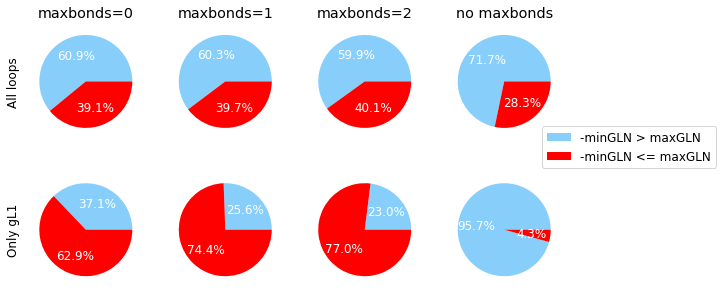

In [29]:
# directions

fig, axs = plt.subplots(2, 4, figsize=(11, 5))
col = ['lightskyblue', 'red']
titles = ['maxbonds=0', 'maxbonds=1', 'maxbonds=2', 'no maxbonds']

for i, t in enumerate(titles):
    L1 = lassoClass(datas[i],"gL1")
    axs[0,i].pie([len(datas[i].loc[datas[i]['mmax']<0]),len(datas[i].loc[datas[i]['mmax']>=0])], colors=col, autopct='%1.1f%%', textprops=dict(color="w"))
    axs[1,i].pie([len(L1.loc[L1['mmax']<0]),len(L1.loc[L1['mmax']>0])], colors=col, autopct='%1.1f%%', textprops=dict(color="w"))
    axs[0,i].set_title(t)
axs[0,0].set_ylabel('All loops')
axs[1,0].set_ylabel('Only gL1')

fig.legend(['-minGLN > maxGLN','-minGLN <= maxGLN'],loc='right')
plt.subplots_adjust(right=0.8)
plt.savefig('results/plots/min-max_all-gL1.png',bbox_inches='tight',pad_inches=0.6,dpi=200)
plt.show()

In [156]:
for data, gLL, t in zip(datas, gLLs, titles):
    L = lassoStats2(data.loc[data['length']>=300], gLL)
    print(sum(L[1:]) / sum(L) * 100)

44.274809160305345
72.51908396946564
75.57251908396947
96.7741935483871


In [11]:
data = datas[-1]
data[(data['mmax']<-6.5)]

,PDB,Loop,BType,tailName,Tails,mmax,class,whole,max,maxTail,maxTails,min,minTail,minTails,WithGaps,length,LoopIdGaps,TailIdGaps
7055,4V9F_0,"(419, 1920)",ncWS,C,"[(8, 418), (1921, 2149), (2226, 2917)]",-6.76,gLS,-5.50,1.26,"(2061, 2149)","[(2061, 2149)]",-6.76,"(1921, 2061)","[(1921, 2061)]",True,2803,True,True
9399,5J7L_DA,"(331, 1209)",ntWW,N,"[(1, 330), (1210, 2502), (2505, 2603), (2606, ...",-6.84,gLS,-6.79,0.35,"(200, 215)","[(200, 215)]",-6.84,"(10, 329)","[(10, 329)]",True,2873,True,False
21738,6TH6_BA,"(1609, 2806)",ncWW,N,"[(10, 1608), (2807, 2892), (2934, 3036)]",-6.53,gLS,-6.06,0.86,"(1508, 1539)","[(1508, 1539)]",-6.53,"(821, 1604)","[(821, 1604)]",True,2877,True,True
21832,6TH6_BA,"(1993, 2518)",tSW,N,"[(10, 1992), (2519, 2892), (2934, 3036)]",-6.57,gLS,-5.93,0.65,"(566, 870)","[(566, 870)]",-6.57,"(870, 1989)","[(870, 1989)]",True,2877,True,True
22093,6TH6_BA,"(452, 1992)",cWS,C,"[(10, 451), (1993, 2892), (2934, 3036)]",-6.71,gLS,-6.44,1.25,"(2132, 2280)","[(2132, 2280)]",-6.71,"(1993, 2132)","[(1993, 2132)]",True,2877,True,True
35291,7KGB_A,"(1695, 2940)",cWW,N,"[(5, 1694), (2941, 3132)]",-6.55,gLS,-6.07,0.83,"(1493, 1532)","[(1493, 1532)]",-6.55,"(824, 1690)","[(824, 1690)]",False,3112,True,True
35293,7KGB_A,"(1699, 2940)",ntSS,N,"[(5, 1698), (2941, 3132)]",-6.53,gLS,-6.04,0.83,"(1493, 1532)","[(1493, 1532)]",-6.53,"(824, 1690)","[(824, 1690)]",False,3112,True,True
36706,7NHN_A,"(1507, 2735)",cWW,N,"[(3, 1506), (2736, 2930)]",-6.53,gLS,-6.06,0.86,"(1406, 1445)","[(1406, 1445)]",-6.53,"(741, 1501)","[(741, 1501)]",False,2908,True,True
42968,7PZY_1,"(2201, 2755)",tSS,N,"[(3, 2200), (2756, 3361)]",-6.53,gLS,-6.03,0.78,"(421, 870)","[(421, 870)]",-6.53,"(870, 2198)","[(870, 2198)]",False,3207,True,True
43167,7PZY_1,"(307, 2200)",ncSS,C,"[(3, 306), (2201, 3361)]",-6.74,gLS,-6.56,1.17,"(2340, 2537)","[(2340, 2537)]",-6.74,"(2201, 3050)","[(2201, 3050)]",False,3207,True,True


In [ ]:
3J7P_S2 (85, 149) 

In [32]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
col = ['lightskyblue','teal', 'plum', 'purple']

i = 0
titles = ['maxbonds=0', 'maxbonds=1', 'maxbonds=2', 'no maxbonds']
for data, gLL, t in zip(datas, gLLs, titles):
    axs[i].pie(lassoStats1(data, gLL, rnas), colors=col, autopct='%1.2f%%', pctdistance=1.3, textprops=dict(color="k"))
    axs[i].set_title(t)
    i += 1
    
fig.suptitle('Most complicated lassos in the analysed RNA structures', size='x-large', y=0.84)
fig.legend(['no loops','gL0','gL1','other'], loc='right')
plt.savefig('results/plots/lrnas.png', bbox_inches='tight', pad_inches=0.2)
plt.close()

fig, axs = plt.subplots(1, 4, figsize=(15, 6))
col = ['teal', 'plum', 'purple']

i = 0
for data, gLL, t in zip(datas, gLLs, titles):
    axs[i].pie(lassoStats2(data.loc[data['length']>=300], gLL), colors=col, autopct='%1.2f%%', textprops=dict(color="w"))
    axs[i].set_title(t)
    i += 1
    
fig.suptitle('Most complicated lassos in RNA structures of length >=300', size='x-large', y=0.84)
fig.legend(['gL0','gL1','other'], loc='right')
plt.savefig('results/plots/lrnas300.png', bbox_inches='tight', pad_inches=0.2)
plt.close()

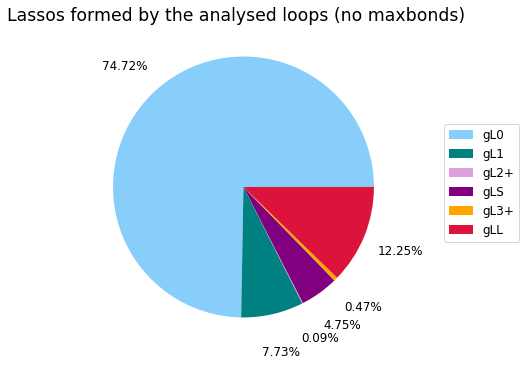

In [31]:
# jakie lassa we wszystkich analizowanych pętlach
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
col = ['lightskyblue','teal', 'plum', 'purple', 'orange', 'crimson']
ax.pie(Ls[-1], colors=col, autopct='%1.2f%%', pctdistance=1.3, textprops=dict(color="k"))
fig.suptitle('Lassos formed by the analysed loops (no maxbonds)', size='x-large', y=0.92)
fig.legend(['gL0','gL1','gL2+','gLS','gL3+','gLL'],loc='right')
plt.savefig('results/plots/lassos_loops.png', bbox_inches='tight')
plt.show()
# gL0,gL1,gL2+,gLS,gL3+,gLL

## Additional analyses
* length of RNA vs maxGLN
* direction of tails going through the loop
* which types of hydrogen bonds are most common in lassos

In [44]:
data.length.max()

3773

In [51]:
sns.set(style="white")
for data, d, t in zip(datas, dirs, titles):
    draw_gln_len(data, title=t, name=f'results/plots/lengths_{d}.png')

In [52]:
for data, d, t in zip(datas, dirs, titles):
    plt.hist(data['mmax'],bins=100)
    plt.xlabel('GLN')
    plt.title(t)
    plt.savefig(f'results/plots/min-max_{d}.png', bbox_inches='tight', pad_inches=0.2, dpi=200)
    plt.close()

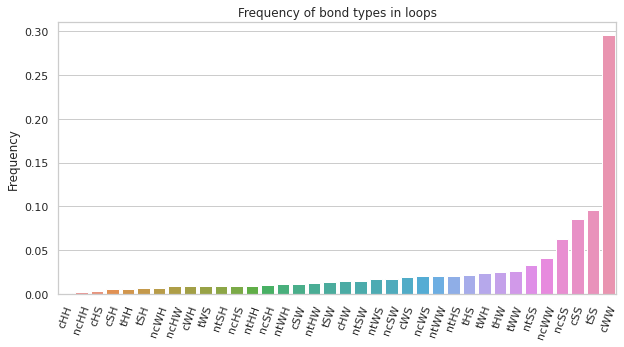

In [112]:
btypes = set(data['BType'])
B = dict(data.groupby(['BType']).size())
del B['wat']
s = sum(B.values())
type_fracs = {k: v/s for k, v in sorted(B.items(), key=lambda item: item[1])}
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
sns.barplot(x=list(type_fracs.keys()), y=list(type_fracs.values()))
plt.xticks(rotation=70)
plt.ylabel('Frequency')
plt.title('Frequency of bond types in loops')
plt.savefig(f'results/plots/bonds/all_loops.png', bbox_inches='tight', pad_inches=0.2, dpi=200)
plt.show()

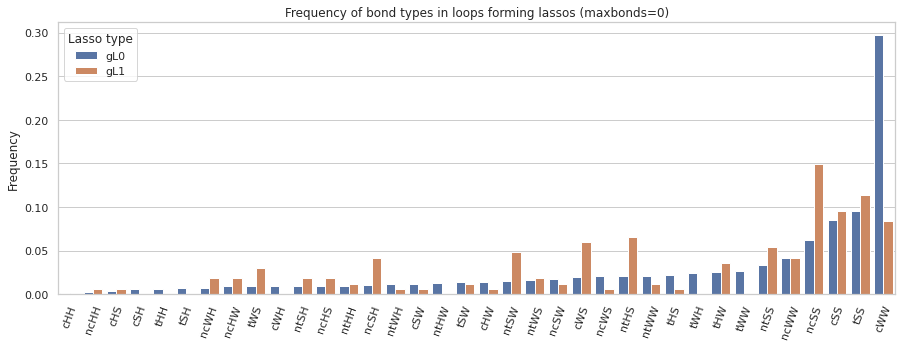

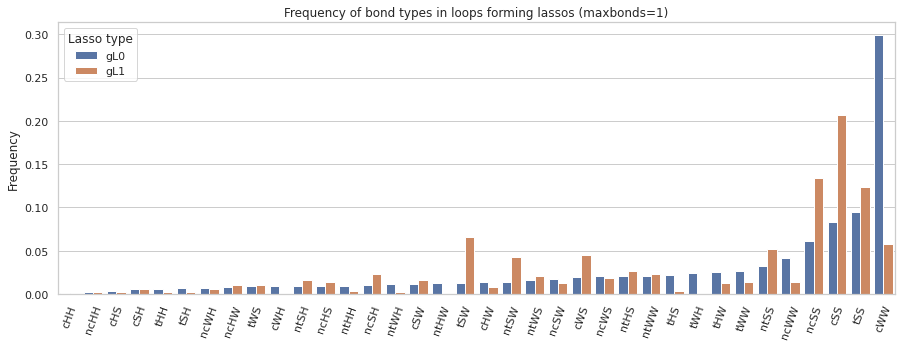

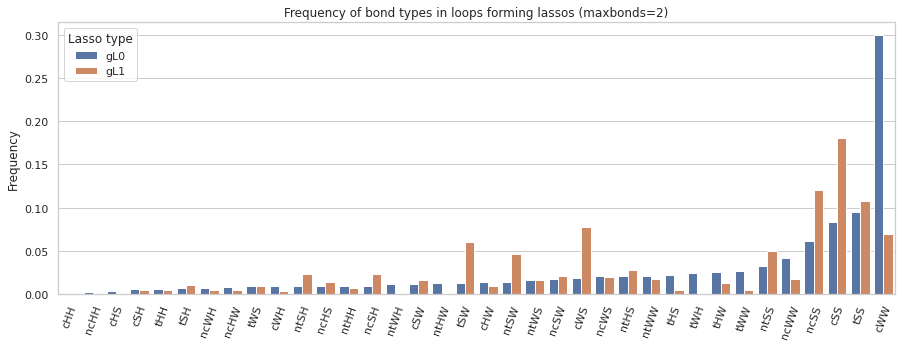

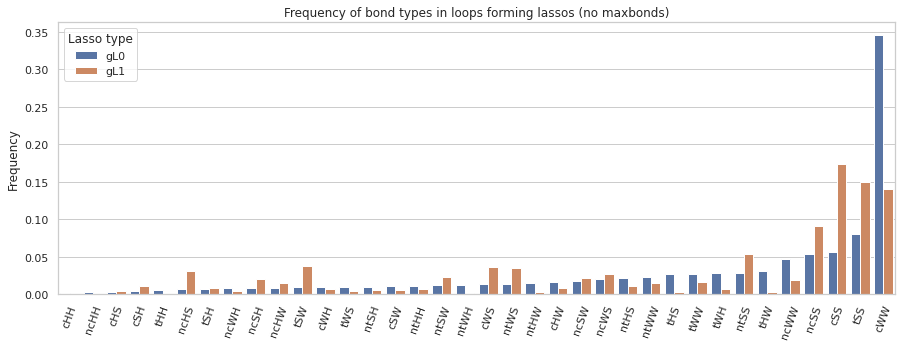

In [111]:
for data, d, t in zip(datas, dirs, titles):  
    B0 = lassoClass(data,'gL0').groupby(['BType']).size()
    B1 = lassoClass(data,'gL1').groupby(['BType']).size()
    B = pd.DataFrame()
    B['gL0'] = B0 / B0.sum()
    B['gL1'] = B1 / B1.sum()
    B = B.sort_values(by='gL0')
    types = B.index
    B = B.fillna(0)
    B = B.melt()
    B = B.rename(columns={'variable':'Lasso type'})
    B['Btype'] = list(types) * 2
    B = B[B.Btype != 'wat']
    plt.figure(figsize=(15,5))
    sns.set(style="whitegrid")
    sns.barplot(x='Btype', y='value', hue='Lasso type', data=B)
    plt.xticks(rotation=70)
    plt.ylabel('Frequency')
    plt.xlabel('')
    plt.title(f'Frequency of bond types in loops forming lassos ({t})')
    plt.savefig(f'results/plots/bonds/{d}.png', bbox_inches='tight', pad_inches=0.2, dpi=200)
    plt.show()

In [109]:
B

,Lasso type,value,Btype
1,gL0,0.000823,cHH
2,gL0,0.002132,ncHH
3,gL0,0.003630,cHS
4,gL0,0.005361,cSH
5,gL0,0.005487,tHH
...,...,...,...
69,gL1,0.041916,ncWW
70,gL1,0.149701,ncSS
71,gL1,0.095808,cSS
72,gL1,0.113772,tSS


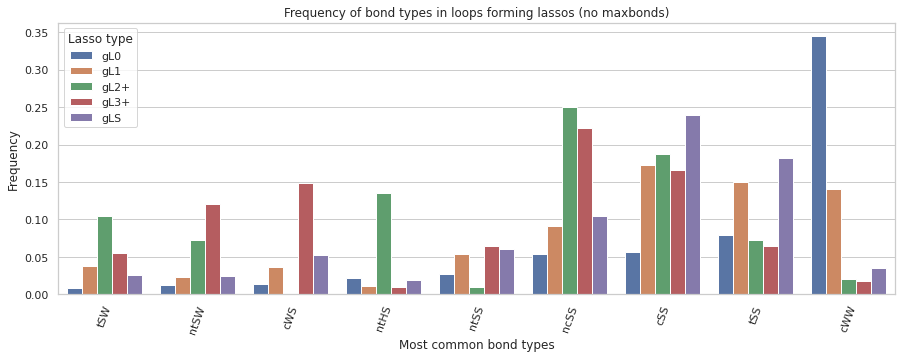

In [117]:
B0 = lassoClass(data,'gL0').groupby(['BType']).size()
B1 = lassoClass(data,'gL1').groupby(['BType']).size()
B2 = lassoClass(data,'gL2+').groupby(['BType']).size()
B3 = lassoClass(data,'gL3+').groupby(['BType']).size()
BS = lassoClass(data,'gLS').groupby(['BType']).size()
B = pd.DataFrame()
B['gL0'] = B0 / B0.sum()
B['gL1'] = B1 / B1.sum()
B['gL2+'] = B2 / B2.sum()
B['gL3+'] = B3 / B3.sum()
B['gLS'] = BS / BS.sum()
B = B.fillna(0)
B = B[B.max(axis=1)>0.05]
B = B.sort_values(by='gL0')
types = B.index
B = B.melt()
B = B.rename(columns={'variable':'Lasso type'})
B['Btype'] = list(types) * 5
B = B[B.Btype != 'wat']
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
sns.barplot(x='Btype', y='value', hue='Lasso type', data=B)
plt.ylabel('Frequency')
plt.xlabel('Most common bond types')
plt.title(f'Frequency of bond types in loops forming lassos (no maxbonds)')
plt.xticks(rotation=70)
plt.savefig('results/plots/bonds/no_maxbonds_all_lassos.png', bbox_inches='tight', pad_inches=0.2, dpi=200)
plt.show()